<a href="https://colab.research.google.com/github/nitixsh/CNN-BILSTM_IDS-Project/blob/main/Hybrid%20CNN-Transforme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np


In [5]:
# Load dataset
df = pd.read_csv("/content/cicids2017_cleaned.csv")

# Clean
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Encode label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

X = df.drop("Label", axis=1).values
y = df["Label"].values

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)


In [7]:
class CNNTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNTransformer, self).__init__()

        # CNN Block
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.flatten_dim = (input_dim // 4) * 128

        # Transformer embedding
        self.embedding = nn.Linear(self.flatten_dim, 256)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=3
        )

        self.dropout = nn.Dropout(0.4)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.flatten(1)
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

model = CNNTransformer(input_dim, num_classes).to(device)


In [9]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train.numpy()),
    y=y_train.numpy()
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)


In [10]:
best_accuracy = 0

for epoch in range(30):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_cnn_transformer.pth")

print("Best Accuracy:", best_accuracy)


Epoch 1, Loss: 30.1065, Accuracy: 99.96%
Epoch 2, Loss: 19.4763, Accuracy: 99.96%
Epoch 3, Loss: 21.4466, Accuracy: 99.96%
Epoch 4, Loss: 24.1405, Accuracy: 99.96%
Epoch 5, Loss: 17.7742, Accuracy: 99.96%
Epoch 6, Loss: 10.6639, Accuracy: 85.04%
Epoch 7, Loss: 19.1655, Accuracy: 99.96%
Epoch 8, Loss: 12.3524, Accuracy: 85.96%
Epoch 9, Loss: 11.7444, Accuracy: 95.95%
Epoch 10, Loss: 9.7044, Accuracy: 92.89%
Epoch 11, Loss: 4.0147, Accuracy: 98.67%
Epoch 12, Loss: 12.0662, Accuracy: 99.96%
Epoch 13, Loss: 11.9232, Accuracy: 99.96%
Epoch 14, Loss: 9.6675, Accuracy: 78.52%
Epoch 15, Loss: 9.5060, Accuracy: 99.96%
Epoch 16, Loss: 7.5354, Accuracy: 91.82%
Epoch 17, Loss: 4.4559, Accuracy: 95.98%
Epoch 18, Loss: 8.4028, Accuracy: 96.83%
Epoch 19, Loss: 11.7439, Accuracy: 97.16%
Epoch 20, Loss: 7.6225, Accuracy: 98.49%
Epoch 21, Loss: 15.7308, Accuracy: 98.64%
Epoch 22, Loss: 13.5536, Accuracy: 98.64%
Epoch 23, Loss: 12.7182, Accuracy: 99.96%
Epoch 24, Loss: 19.1453, Accuracy: 99.96%
Epoch 25,

In [11]:
model.load_state_dict(torch.load("best_cnn_transformer.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2713
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2714
   macro avg       0.50      0.50      0.50      2714
weighted avg       1.00      1.00      1.00      2714



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
pip install torch torchvision scikit-learn pandas matplotlib seaborn


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
df = pd.read_csv("/content/cicids2017_cleaned.csv")

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

X = df.drop("Label", axis=1).values
y = df["Label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=256, shuffle=True)

test_loader = DataLoader(TensorDataset(X_test, y_test),
                         batch_size=256)


In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class AdvancedCNNTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.res1 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool1d(2)

        self.flatten_dim = (input_dim // 2) * 128

        self.embedding = nn.Linear(self.flatten_dim, 256)
        self.norm = nn.LayerNorm(256)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = self.pool(x)
        x = x.flatten(1)
        x = self.embedding(x)
        x = self.norm(x)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.dropout(x)
        return self.fc(x)


In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [19]:
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

model = AdvancedCNNTransformer(input_dim, num_classes).to(device)

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [20]:
train_losses = []
test_accuracies = []

best_acc = 0
patience = 5
early_stop_counter = 0

for epoch in range(40):

    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()

    acc = 100 * correct / total

    train_losses.append(total_loss)
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1} | Loss {total_loss:.4f} | Acc {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_model.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

print("Best Accuracy:", best_acc)


Epoch 1 | Loss 48.4670 | Acc 99.18%
Epoch 2 | Loss 26.1332 | Acc 97.97%
Epoch 3 | Loss 23.4832 | Acc 99.61%
Epoch 4 | Loss 21.3429 | Acc 99.39%
Epoch 5 | Loss 20.6724 | Acc 99.56%
Epoch 6 | Loss 19.3172 | Acc 99.71%
Epoch 7 | Loss 18.6326 | Acc 99.76%
Epoch 8 | Loss 18.7833 | Acc 99.61%
Epoch 9 | Loss 17.4750 | Acc 99.51%
Epoch 10 | Loss 17.2090 | Acc 99.45%
Epoch 11 | Loss 13.7332 | Acc 99.75%
Epoch 12 | Loss 13.8145 | Acc 99.75%
Early stopping triggered
Best Accuracy: 99.75709983154384


Loss Graph

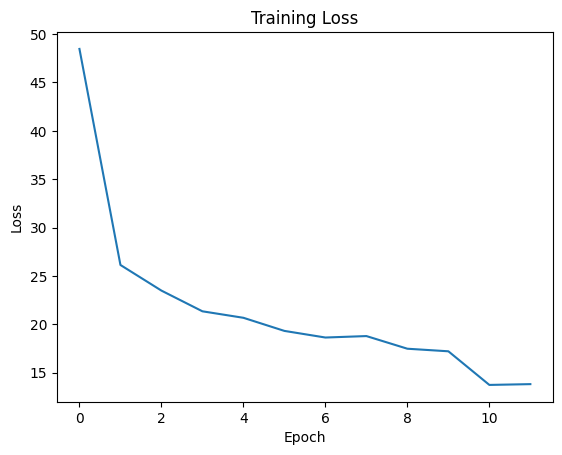

In [21]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Accuracy Graph

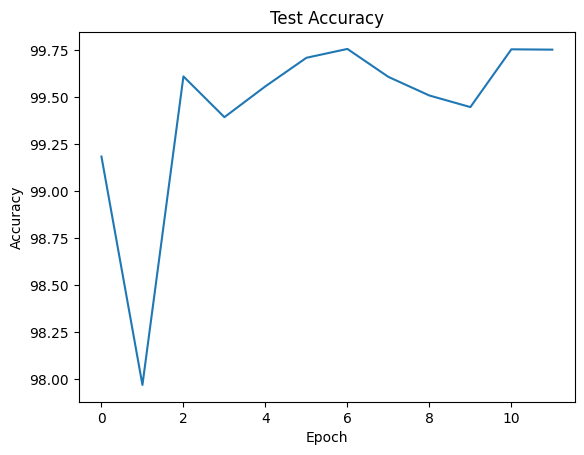

In [22]:
plt.figure()
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Confusion Matrix

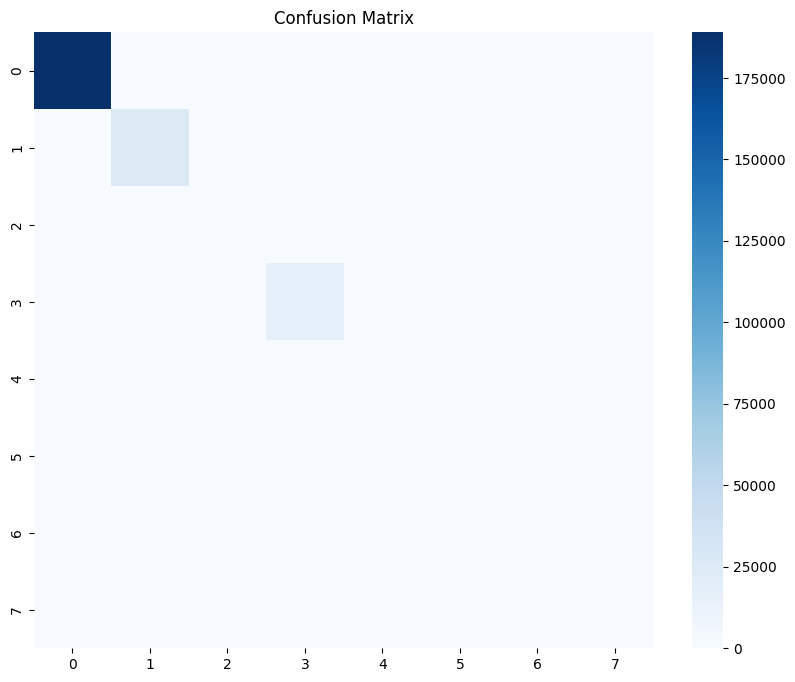

In [23]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


ROC Curve (Multi-class)

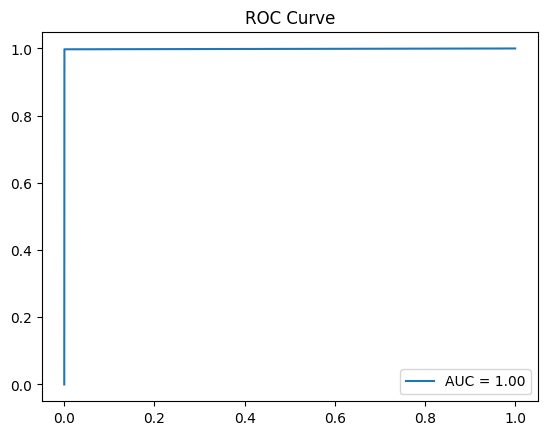

In [24]:
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(all_labels, classes=range(num_classes))
pred_bin = label_binarize(all_preds, classes=range(num_classes))

fpr, tpr, _ = roc_curve(y_bin.ravel(), pred_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.legend()
plt.title("ROC Curve")
plt.show()


Step 1: Keep Attack Names

In [37]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

class_names = le.classes_
print("Detected Attack Types:")
print(class_names)

print("Detected Attack Types:")
print(le)



Detected Attack Types:
[0 1 2 3 4 5 6 7]
Detected Attack Types:
LabelEncoder()


In [38]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.numpy())

# Convert numbers to attack names
pred_attack_names = le.inverse_transform(all_preds)
true_attack_names = le.inverse_transform(all_labels)


In [39]:
print(classification_report(
    true_attack_names,
    pred_attack_names
))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    189076
           1       1.00      1.00      1.00     25603
           2       1.00      0.99      0.99      1186
           3       1.00      1.00      1.00     18139
           4       0.94      0.94      0.94       644
           5       0.00      0.00      0.00       294
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00       130

    accuracy                           1.00    235076
   macro avg       0.62      0.62      0.62    235076
weighted avg       1.00      1.00      1.00    235076



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


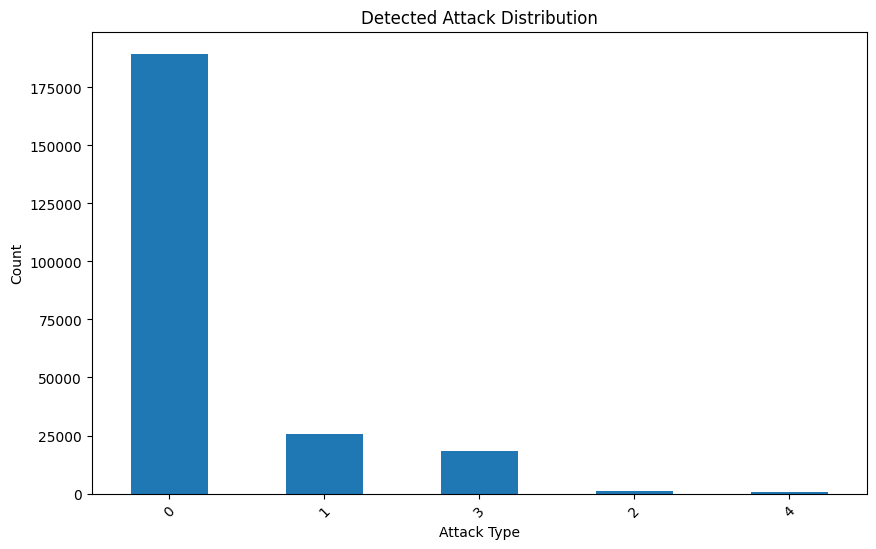

In [40]:
attack_counts = pd.Series(pred_attack_names).value_counts()

plt.figure(figsize=(10,6))
attack_counts.plot(kind='bar')
plt.title("Detected Attack Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


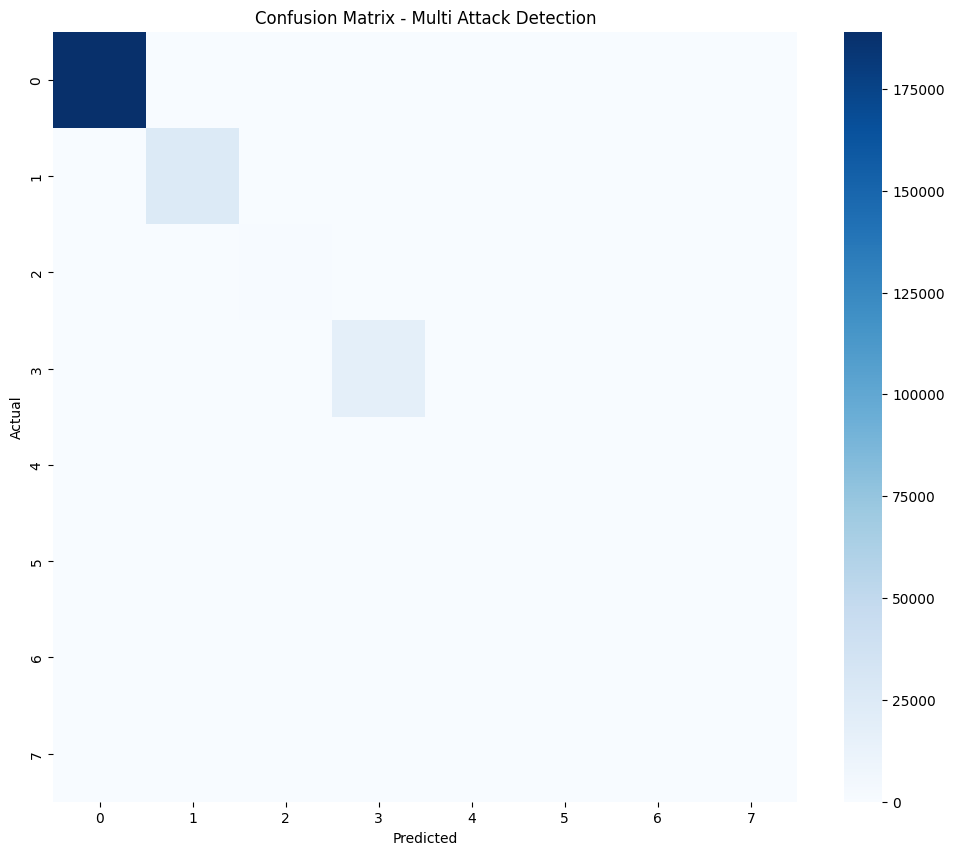

In [41]:
cm = confusion_matrix(true_attack_names, pred_attack_names)

plt.figure(figsize=(12,10))
sns.heatmap(cm,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues",
            fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Multi Attack Detection")
plt.show()


In [50]:
def detect_attacks(file_path):
    df_new = pd.read_csv("/content/UNSW-NB15_1.csv")

    df_new.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_new.dropna(inplace=True)

    X_new = df_new.drop("Label", axis=1).values
    X_new = scaler.transform(X_new)

    X_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)

    attack_names = le.inverse_transform(predicted.cpu().numpy())

    df_new["Predicted_Attack"] = attack_names

    return df_new
